# Data Anlysis Yammer

#  1. Investigating a Drop in User Engagement

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from fastai.imports import *
from fastai.structured import *
from IPython.display import display
from sklearn import metrics

%matplotlib inline

In [2]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [3]:
PATH = "data/mode/"

In [4]:
emails = pd.read_csv(f'{PATH}emails.csv', low_memory=False)
exp = pd.read_csv(f'{PATH}experiments.csv', low_memory=False)
users = pd.read_csv(f'{PATH}users.csv', low_memory=False,  parse_dates=['created_at'])
sessions = pd.read_csv(f'{PATH}user_sessions.csv', low_memory=False, parse_dates = ['occurred_at'])

## Initial Exploration

In [5]:
def name_dataframes(dfList, dfNames):
    for df, name in zip(dfList, dfNames):
        df.name = name
    return

dfList = [emails, exp, users, sessions]
dfNames = ['emails', 'exp', 'users', 'sessions']
name_dataframes(dfList, dfNames)

In [6]:
for df in dfList:
    print(df.name + ":\n" , df.columns)

emails:
 Index(['user_id', 'occurred_at', 'action', 'user_type'], dtype='object')
exp:
 Index(['user_id', 'occurred_at', 'experiment', 'experiment_group', 'location',
       'device', 'user_type'],
      dtype='object')
users:
 Index(['user_id', 'created_at', 'company_id', 'language', 'activated_at',
       'state'],
      dtype='object')
sessions:
 Index(['user_id', 'occurred_at', 'event_type', 'event_name', 'location',
       'device', 'user_type'],
      dtype='object')


In [7]:
users.head(2)

,user_id,created_at,company_id,language,activated_at,state
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active
1,1.0,2013-01-01 13:07:46,28.0,english,NaN,pending


In [8]:
sessions.head(2)

,user_id,occurred_at,event_type,event_name,location,device,user_type
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0


In [9]:
emails.head(2)

,user_id,occurred_at,action,user_type
0,0.0,2014-05-06 09:30:00,sent_weekly_digest,1.0
1,0.0,2014-05-13 09:30:00,sent_weekly_digest,1.0


In [10]:
exp.head(2)

,user_id,occurred_at,experiment,experiment_group,location,device,user_type
0,4.0,2014-06-05 15:20:16,publisher_update,control_group,India,lenovo thinkpad,3.0
1,8198.0,2014-06-11 09:31:32,publisher_update,control_group,Japan,nokia lumia 635,1.0


In [11]:
def data_summary(df):
    '''print out information about dataframe
    Argument: dataframe name
    Return: dataframe with summary figures
    '''
    temp = pd.DataFrame(data = df.isnull().sum(axis=0))
    temp.columns=['NA count']
    temp['NA %'] = temp['NA count']/(df.shape[0])*100
    temp['# unique vals'] = df.nunique(axis=0)
    temp['dtype'] =  df.dtypes
    temp['dataset'] = df.name
    
    return temp

In [12]:
data_summary(sessions)

,NA count,NA %,# unique vals,dtype,dataset
user_id,0,0.000000,9760,float64,sessions
occurred_at,0,0.000000,304922,datetime64[ns],sessions
event_type,0,0.000000,2,object,sessions
event_name,0,0.000000,21,object,sessions
location,0,0.000000,47,object,sessions
device,0,0.000000,26,object,sessions
user_type,15577,4.570287,3,float64,sessions


In [13]:
data_summary(users)

,NA count,NA %,# unique vals,dtype,dataset
user_id,0,0.000000,19066,float64,users
created_at,0,0.000000,19056,datetime64[ns],users
company_id,0,0.000000,13198,float64,users
language,0,0.000000,12,object,users
activated_at,9685,50.797231,9379,object,users
state,0,0.000000,2,object,users


In [14]:
data_summary(emails)

,NA count,NA %,# unique vals,dtype,dataset
user_id,0,0.0,6179,float64,emails
occurred_at,0,0.0,14772,object,emails
action,0,0.0,4,object,emails
user_type,0,0.0,3,float64,emails


In [15]:
data_summary(exp)

,NA count,NA %,# unique vals,dtype,dataset
user_id,0,0.0,2595,float64,exp
occurred_at,0,0.0,2160,object,exp
experiment,0,0.0,1,object,exp
experiment_group,0,0.0,2,object,exp
location,0,0.0,47,object,exp
device,0,0.0,26,object,exp
user_type,0,0.0,3,float64,exp


Each user is in the experient once

In [16]:
exp.shape

(2595, 7)

In [17]:
sessions['event_type'].value_counts(normalize = True)

engagement     0.9435
signup_flow    0.0565
Name: event_type, dtype: float64

In [18]:
pd.crosstab(sessions['event_type'], sessions['event_name'], normalize= True)

event_name,complete_signup,create_user,enter_email,enter_info,home_page,like_message,login,search_autocomplete,search_click_result_1,search_click_result_10,...,search_click_result_3,search_click_result_4,search_click_result_5,search_click_result_6,search_click_result_7,search_click_result_8,search_click_result_9,search_run,send_message,view_inbox
event_type,,,,,,,,,,,,,,,,,,,,,
engagement,0.000000,0.000000,0.00000,0.00000,0.275986,0.173833,0.113282,0.052284,0.004146,0.001485,...,0.003327,0.003709,0.00284,0.002362,0.00208,0.002024,0.0023,0.038198,0.09713,0.164116
signup_flow,0.010797,0.021412,0.01293,0.01136,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0000,0.000000,0.00000,0.000000


## Calculate the Engagement Metrics

The number of users who logged at least one engagement event during the week starting on that date.

In [19]:
sessions = sessions.sort_values(by = 'occurred_at')

In [20]:
# filter sessions to engagement events only
eng = sessions.loc[sessions['event_type']== 'engagement', ['user_id', 'occurred_at']]

In [21]:
# get last observation of each user_id, date combination
eng['date'] = eng['occurred_at'].dt.date
eng = eng.drop_duplicates(subset=['user_id', 'date'], keep='first')
eng = eng[['user_id', 'date']]
eng.shape
eng['date'] = pd.to_datetime(eng['date'])

In [22]:
# Calculate 7 day rolling count of unqiue users
temp = eng.rolling(window='7D', on='date').apply(lambda x: pd.Series(x).nunique(), raw=False)
temp = temp.drop_duplicates(subset=['date'], keep = 'last')
temp = temp.reset_index(drop = True)
temp = temp[temp['date'] >= '2014-05-07'] # to get at least 7 day history
temp = temp.set_index('date')

In [23]:
temp.tail()

,user_id
date,
2014-08-27,1172.0
2014-08-28,1175.0
2014-08-29,1202.0
2014-08-30,1204.0
2014-08-31,1194.0


Text(0.5,1,'7 Day Rolling Period User Engagement Count')

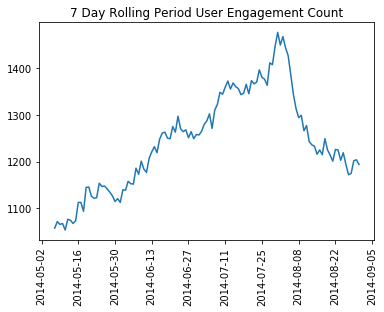

In [24]:
fig = plt.figure()
plt.plot(temp['user_id'])
plt.xticks(rotation=90)
plt.title('7 Day Rolling Period User Engagement Count')

## Merge Dataset

#### Merge Sessions with Users

Merge sessions with users

In [25]:
df = sessions.merge(users, how = 'left', on = 'user_id')
df.shape

(340832, 12)

In [26]:
df.columns

Index(['user_id', 'occurred_at', 'event_type', 'event_name', 'location',
       'device', 'user_type', 'created_at', 'company_id', 'language',
       'activated_at', 'state'],
      dtype='object')

#### Add datetime columns

In [27]:
df['date'] = df['occurred_at'].dt.date
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['week'] = df['date'].dt.week

#### Merge with emails

In [28]:
emails.head()

,user_id,occurred_at,action,user_type
0,0.0,2014-05-06 09:30:00,sent_weekly_digest,1.0
1,0.0,2014-05-13 09:30:00,sent_weekly_digest,1.0
2,0.0,2014-05-20 09:30:00,sent_weekly_digest,1.0
3,0.0,2014-05-27 09:30:00,sent_weekly_digest,1.0
4,0.0,2014-06-03 09:30:00,sent_weekly_digest,1.0


In [29]:
emails['action'].value_counts(normalize = True)

sent_weekly_digest         0.633562
email_open                 0.226344
email_clickthrough         0.099680
sent_reengagement_email    0.040414
Name: action, dtype: float64

One-hot encode e-mails action to summarize user action by date

In [30]:
temp = pd.get_dummies(emails['action'], dummy_na = False)
temp = temp.add_prefix('email_action_')
emails = pd.concat([emails, temp], axis=1) # add columns horizontally

In [31]:
emails['occurred_at'] = pd.to_datetime(emails['occurred_at'])
emails['date'] = emails['occurred_at'].dt.date
emails['date'] = pd.to_datetime(emails['date'])

In [32]:
temp = emails.groupby(['user_id', 'date'])['email_action_email_clickthrough', 'email_action_email_open',
       'email_action_sent_reengagement_email',
       'email_action_sent_weekly_digest'].sum()

In [33]:
temp = temp.reset_index()

In [34]:
temp.head()

,user_id,date,email_action_email_clickthrough,email_action_email_open,email_action_sent_reengagement_email,email_action_sent_weekly_digest
0,0.0,2014-05-06,0,0,0,1
1,0.0,2014-05-13,0,0,0,1
2,0.0,2014-05-20,0,0,0,1
3,0.0,2014-05-27,0,0,0,1
4,0.0,2014-06-03,0,1,0,1


Merge emails to df

In [35]:
df = df.merge(temp, how = 'left', left_on = ['user_id', 'date'], right_on=['user_id', 'date'])

#### Merge with Experiments

In [36]:
exp.head()

,user_id,occurred_at,experiment,experiment_group,location,device,user_type
0,4.0,2014-06-05 15:20:16,publisher_update,control_group,India,lenovo thinkpad,3.0
1,8198.0,2014-06-11 09:31:32,publisher_update,control_group,Japan,nokia lumia 635,1.0
2,11.0,2014-06-17 09:31:22,publisher_update,control_group,United States,iphone 4s,1.0
3,8209.0,2014-06-04 09:31:21,publisher_update,test_group,Turkey,nokia lumia 635,1.0
4,19.0,2014-06-04 09:31:33,publisher_update,test_group,Nigeria,iphone 5,1.0


In [37]:
exp = pd.read_csv(f'{PATH}experiments.csv', low_memory=False)

In [38]:
exp['occurred_at'] = pd.to_datetime(exp['occurred_at'])
exp['date'] = exp['occurred_at'].dt.date
exp['date'] = pd.to_datetime(exp['date'])

In [39]:
exp = exp.drop(['experiment'], axis = 1)  # only one experiment in this dataset
exp = exp.add_prefix('exp_')

In [40]:
df = df.merge(exp, how = 'left', left_on = ['user_id', 'date'], right_on = ['exp_user_id', 'exp_date'])

#### Define coherts to meausure time on platform

In [41]:
df['daysOnPlatform'] = df['occurred_at'] - pd.to_datetime(df['activated_at'])

In [42]:
df['daysOnPlatform'] = df['daysOnPlatform'].dt.days

In [43]:
df['daysOnPlatform'] = np.where(df['daysOnPlatform']<0, 0, df['daysOnPlatform'])

In [44]:
df['cohert'] = pd.cut(df['daysOnPlatform'], bins = [-1, 7, 15, 30, 90, 180, 360, df['daysOnPlatform'].max()],
                     labels =  ['<7d', '<15d', '<30d', '<90d', '<180d', '<360d', '>360d'])
df['cohert'] = df['cohert'].astype('object')
df['cohert'] = df['cohert'].fillna('na')

In [45]:
df.isnull().sum(axis = 0)

user_id                                      0
occurred_at                                  0
event_type                                   0
event_name                                   0
location                                     0
device                                       0
user_type                                15577
created_at                                   0
company_id                                   0
language                                     0
activated_at                              4537
state                                        0
date                                         0
month                                        0
day                                          0
weekday                                      0
week                                         0
email_action_email_clickthrough         238497
email_action_email_open                 238497
email_action_sent_reengagement_email    238497
email_action_sent_weekly_digest         238497
exp_user_id  

Fill NA for plotting purposes.  Plot NA as a separate category.

In [46]:
df = df.fillna('na')

In [47]:
df.dtypes

user_id                                        float64
occurred_at                             datetime64[ns]
event_type                                      object
event_name                                      object
location                                        object
device                                          object
user_type                                       object
created_at                              datetime64[ns]
company_id                                     float64
language                                        object
activated_at                                    object
state                                           object
date                                    datetime64[ns]
month                                            int64
day                                              int64
weekday                                          int64
week                                             int64
email_action_email_clickthrough                 object
email_acti

In [48]:
df.columns

Index(['user_id', 'occurred_at', 'event_type', 'event_name', 'location',
       'device', 'user_type', 'created_at', 'company_id', 'language',
       'activated_at', 'state', 'date', 'month', 'day', 'weekday', 'week',
       'email_action_email_clickthrough', 'email_action_email_open',
       'email_action_sent_reengagement_email',
       'email_action_sent_weekly_digest', 'exp_user_id', 'exp_occurred_at',
       'exp_experiment_group', 'exp_location', 'exp_device', 'exp_user_type',
       'exp_date', 'daysOnPlatform', 'cohert'],
      dtype='object')

## Calculate Engagement by different groups of aggregation

* Simplify calculation.  Instead of rolling 7 days, using week of the year as approximation. 
* The drop started around 2014-07-25, which is around week 30

#### Mapping for Week

In [49]:
map_wk_date = df.groupby(['week'])['date'].first()

In [50]:
df['weekof'] = df['week'].map(map_wk_date).dt.date

#### Define Function for Plots

In [51]:
def decomposition(col):
    temp = df.loc[df['event_type']== 'engagement']
    temp = temp.groupby(['weekof', col])['user_id'].agg('nunique')
    temp = temp.unstack()
    #temp['weekly_total'] = temp.sum(axis = 1)
    biggestCountries = temp.sum(axis = 0)
    temp = temp.reset_index(drop = False)
    top10 = biggestCountries.nlargest(11).index
    
    chart_data = pd.melt(temp, id_vars = 'weekof')
    chart_data = chart_data[(chart_data[col].isin(top10)) & (chart_data[col]!='weekly_total')]
    #chart_data = chart_data[(chart_data[col].isin(top10))]
    return chart_data

def plot_decomposition(col):
    plt.figure(figsize=(12,10))
    g = sns.factorplot(x='weekof', y='value', hue=col, data=chart_data, size = 4, aspect = 2)
    plt.xticks(rotation=90)
    
    return None

#### Location

Big drop comes from the US.

<Figure size 864x720 with 0 Axes>

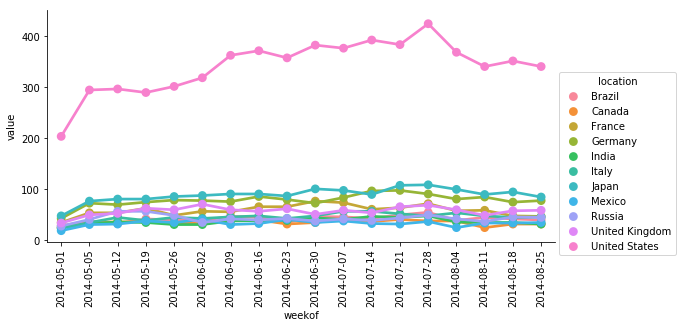

In [52]:
col = 'location'
chart_data = decomposition(col)
plot_decomposition(col)

#### Device

No notable drop across different device.  Slightly more drop in phones?

<Figure size 864x720 with 0 Axes>

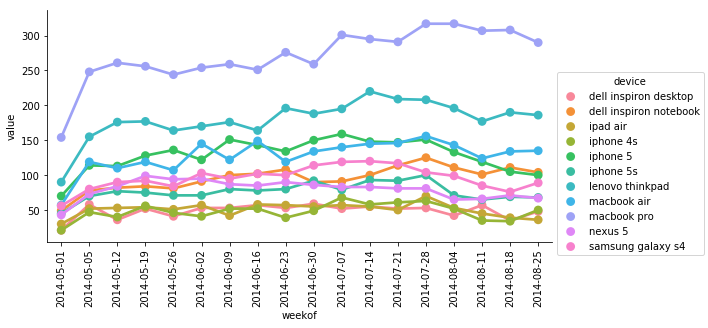

In [53]:
col = 'device'
chart_data = decomposition(col)
plot_decomposition(col)

#### User Type

Big drop in user type 1 and 2

<Figure size 864x720 with 0 Axes>

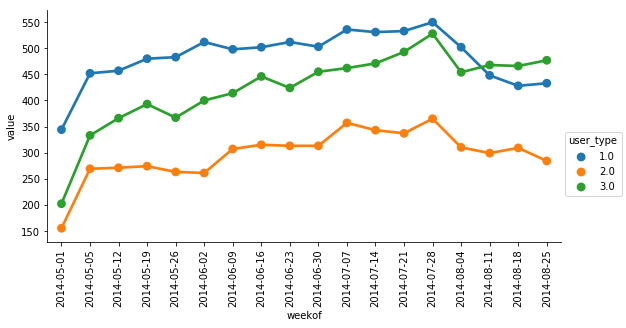

In [54]:
col = 'user_type'
chart_data = decomposition(col)
plot_decomposition(col)

<Figure size 864x720 with 0 Axes>

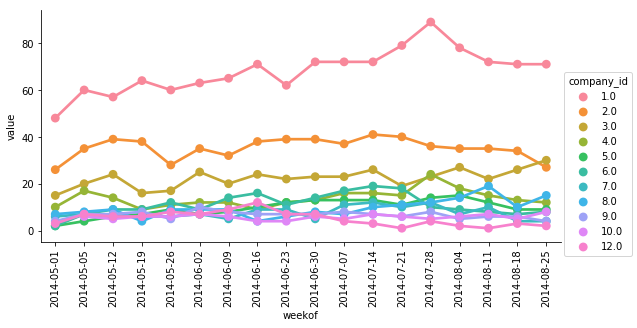

In [55]:
col = 'company_id'
chart_data = decomposition(col)
plot_decomposition(col)

<Figure size 864x720 with 0 Axes>

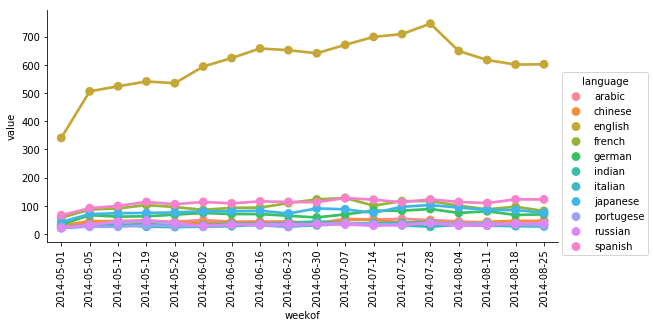

In [56]:
col = 'language'
chart_data = decomposition(col)
plot_decomposition(col)

Weekend usage remained stable while weekdays dropped.

<Figure size 864x720 with 0 Axes>

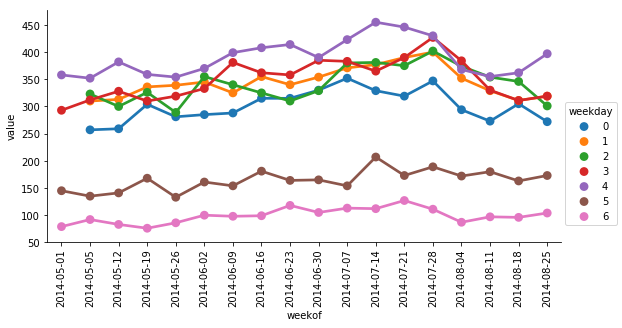

In [57]:
col = 'weekday' # The day of the week with Monday=0, Sunday=6
chart_data = decomposition(col)
plot_decomposition(col)

Seems to be a problem with e-mail digest.  The users didn't receive it have stable engagement, while there's big drop for the one's who received it.

<Figure size 864x720 with 0 Axes>

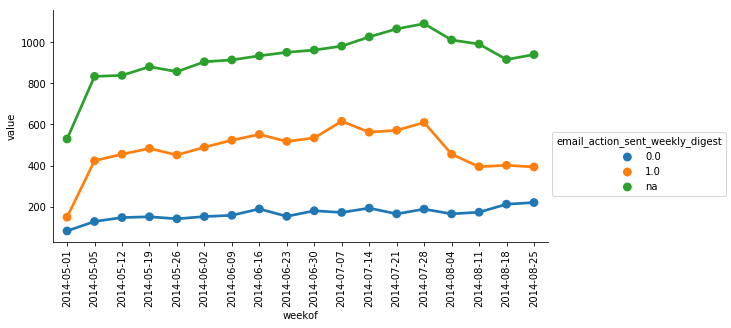

In [58]:
col = 'email_action_sent_weekly_digest' 
chart_data = decomposition(col)
plot_decomposition(col)

<Figure size 864x720 with 0 Axes>

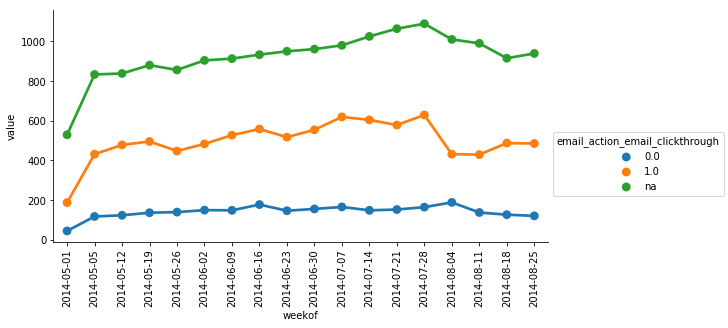

In [59]:
col = 'email_action_email_clickthrough'
chart_data = decomposition(col)
plot_decomposition(col)

<Figure size 864x720 with 0 Axes>

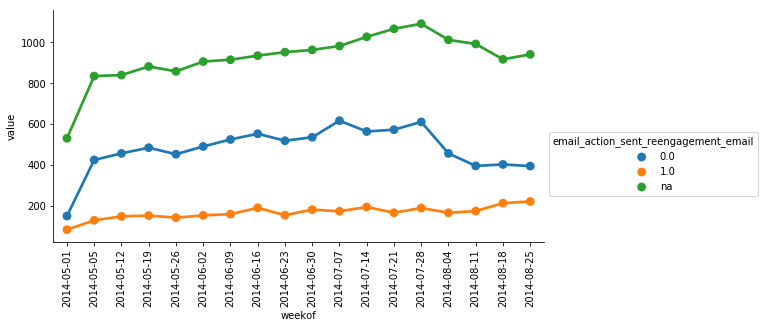

In [60]:
col = 'email_action_sent_reengagement_email'
chart_data = decomposition(col)
plot_decomposition(col)

<Figure size 864x720 with 0 Axes>

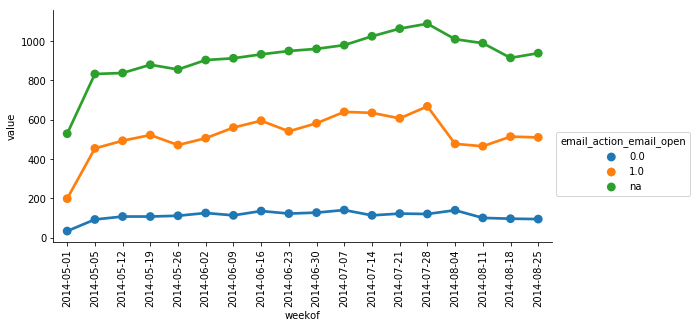

In [61]:
col = 'email_action_email_open'
chart_data = decomposition(col)
plot_decomposition(col)

More drops in longer term users

<Figure size 864x720 with 0 Axes>

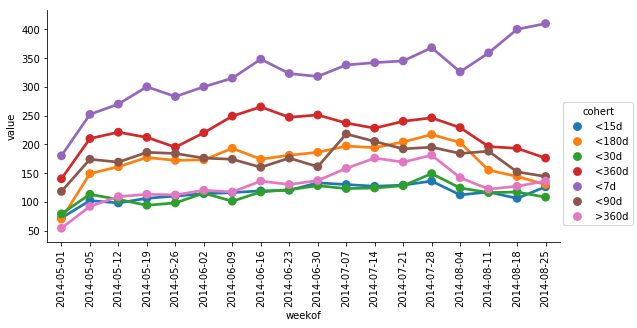

In [62]:
col = 'cohert'
chart_data = decomposition(col)
plot_decomposition(col)

<Figure size 864x720 with 0 Axes>

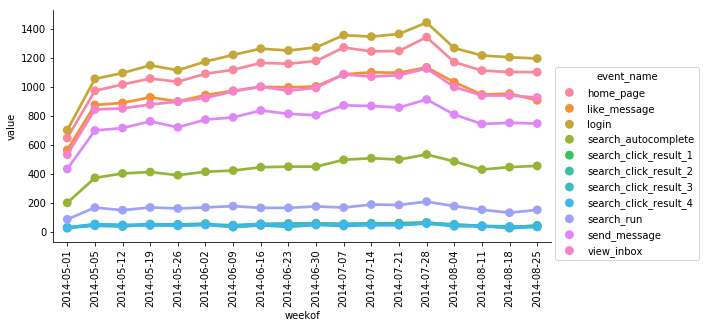

In [63]:
col = 'event_name'
chart_data = decomposition(col)
plot_decomposition(col)

In [64]:
chart_data.head()

,weekof,event_name,value
0,2014-05-01,home_page,646
1,2014-05-05,home_page,972
2,2014-05-12,home_page,1015
3,2014-05-19,home_page,1056
4,2014-05-26,home_page,1034


In [65]:
chart_data['value_lag'] = chart_data.groupby('event_name')['value'].shift(1)
chart_data['diff'] = chart_data['value'] - chart_data['value_lag']
chart_data['percent_change'] = chart_data['value']/chart_data['value_lag']-1

Text(0.5,1,'Week over week percentage change')

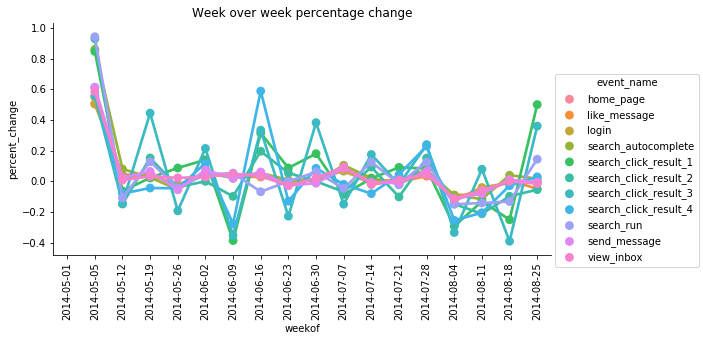

In [66]:
g = sns.factorplot(x='weekof', y='percent_change', hue='event_name', data=chart_data, size = 4, aspect = 2)
plt.xticks(rotation=90)
plt.title('Week over week percentage change')

Text(0.5,1,'Week over week engagement change')

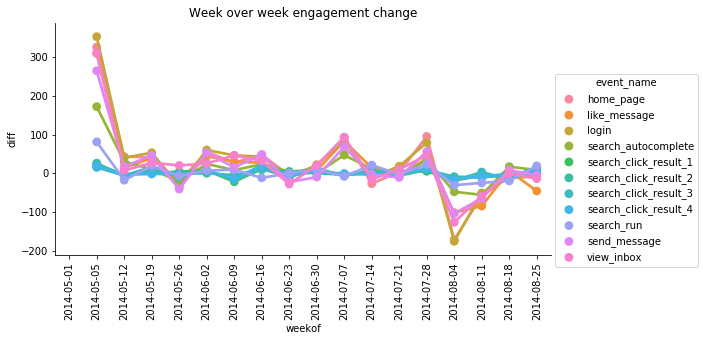

In [67]:
g = sns.factorplot(x='weekof', y='diff', hue='event_name', data=chart_data, size = 4, aspect = 2)
plt.xticks(rotation=90)
plt.title('Week over week engagement change')

In [68]:
chart_data.loc[chart_data['weekof'] == dt.date(2014,8,4)]

,weekof,event_name,value,value_lag,diff,percent_change
14,2014-08-04,home_page,1169,1341.0,-172.0,-0.128262
32,2014-08-04,like_message,1031,1133.0,-102.0,-0.090026
50,2014-08-04,login,1266,1442.0,-176.0,-0.122053
68,2014-08-04,search_autocomplete,485,533.0,-48.0,-0.090056
86,2014-08-04,search_click_result_1,46,65.0,-19.0,-0.292308
122,2014-08-04,search_click_result_2,52,61.0,-9.0,-0.147541
140,2014-08-04,search_click_result_3,38,57.0,-19.0,-0.333333
158,2014-08-04,search_click_result_4,44,59.0,-15.0,-0.254237
266,2014-08-04,search_run,177,208.0,-31.0,-0.149038
284,2014-08-04,send_message,808,912.0,-104.0,-0.114035


#### Changes in Sign-up Rate

No abnormality is observed in the Sign-up Rate.

In [69]:
users['date'] = users['created_at'].dt.date
users['date'] = pd.to_datetime(users['date'])

In [70]:
temp = users.groupby(['date', 'state'])['user_id'].agg('nunique')
temp = temp.unstack().reset_index()
temp = pd.melt(temp, 'date')
temp = temp.loc[temp['date'] > '2014-07-01']
temp['date'] = temp['date'].astype(str)

[]

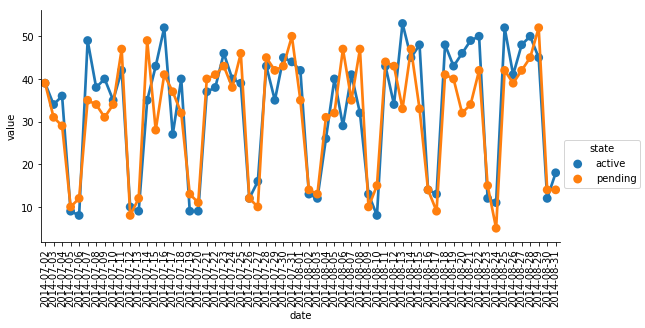

In [71]:
g = sns.factorplot(x='date', y='value', hue='state', data=temp, size = 4, aspect = 2)
plt.xticks(rotation=90)
plt.plot()

#### A closer look at 'email_action_email_clickthrough' to see which date the decline in engagement happened


Weekly seasonality is stable.  However, e-mail clickthrough suddenly dropped.

In [72]:
temp = df.groupby(['date', 'email_action_email_clickthrough'])['user_id'].agg('nunique')
temp = temp.unstack().reset_index()
temp = pd.melt(temp, 'date')
temp = temp.loc[temp['date'] > '2014-07-01']
temp['date'] = temp['date'].astype(str)

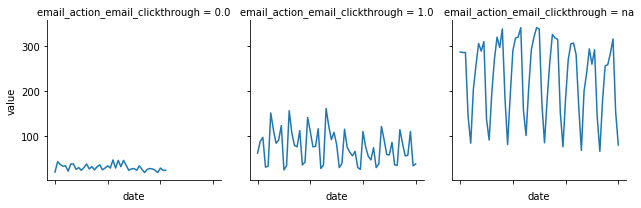

In [73]:
def dateplot(x, y, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    data.plot(x=x, y=y, ax=ax, grid=False, **kwargs)
    
g = sns.FacetGrid(temp, col="email_action_email_clickthrough")
g = g.map_dataframe(dateplot, "date", "value")

# 2. Analyzing Search Function Effectiveness

Are users’ search experiences generally good or bad?
Is search worth working on at all?
If search is worth working on, what, specifically, should be improved?

a session is defined as a string of events logged by a user without a 10-minute break between any two events. So if a user goes 10 minutes without logging an event, the session is ended and her next engagement will be considered a new session.

* search_autocomplete: This is logged when a user clicks on a search option from autocomplete
* search_run: This is logged when a user runs a search and sees the search results page.
* search_click_X: This is logged when a user clicks on a search result. X, which ranges from 1 to 10, describes which search result was clicked.

#### Add new columns to identify sessions

In [74]:
df = df.sort_values(by = ['user_id', 'occurred_at']).reset_index(drop = True)
df['lag1'] = df.groupby('user_id')['occurred_at'].shift(1)
df['diff'] = df['occurred_at'] - df['lag1']
df['newSession'] = df['diff']>= dt.timedelta(minutes=10)
df.loc[df['diff'].isnull(), 'newSession'] = True
df['user_session_num'] = df['newSession'].groupby(df['user_id']).cumsum()
df['session_num'] = df['newSession'].cumsum()

#### Add new columns to identify search

In [75]:
df['searchFlag'] = df['event_name'].str.contains('search')
df['searchRun'] = df['event_name'] == 'search_run'
df['searchAC'] = df['event_name'] == 'search_autocomplete'
df['search_click'] = df['event_name'].str.contains('search_click')
df['action_lag_1'] = df.groupby(['user_id', 'user_session_num'])['event_name'].shift(1)
df['action_lag_2'] = df.groupby(['user_id', 'user_session_num'])['event_name'].shift(2)

In [76]:
df['action_seq_2'] = df['action_lag_2'].astype(str).str.cat('.'+df['action_lag_1'].astype(str)).str.cat('.'+df['event_name'].astype(str))

In [77]:
conditions = [(df['event_name'] == 'search_run'),
              (df['event_name'] == 'search_autocomplete'),
              (df['event_name'].str.contains('search_click'))
             ]
choices = ['run', 'ac', 'click']
df['search_action'] = np.select(conditions, choices)

df['search_action_lag_1'] = df.groupby(['user_id', 'user_session_num'])['search_action'].shift(1)
df['search_action_lag_2'] = df.groupby(['user_id', 'user_session_num'])['search_action'].shift(2)

In [78]:
df['search_seq'] = df['search_action_lag_1'].astype(str).str.cat('.'+df['search_action'].astype(str))

In [79]:
df['search_seq_2'] = df['search_action_lag_2'].astype(str).str.cat('.'+df['search_action_lag_1'].astype(str)).str.cat('.'+df['search_action'].astype(str))

In [80]:
sessions = sessions.sort_values(by = ['user_id', 'occurred_at'])
sessions = sessions.reset_index(drop = True)
sessions['lag1'] = sessions.groupby('user_id')['occurred_at'].shift(1) 
sessions['diff'] = sessions['occurred_at'] - sessions['lag1']
sessions['newSession'] = sessions['diff']>= dt.timedelta(minutes=10)
sessions['session_num'] = sessions['newSession'].groupby(sessions['user_id']).cumsum() + 1

#### Percentage of sessions with search

In [81]:
temp  = df.groupby('session_num')['searchFlag'].sum()

In [82]:
print('% of sessions that used search:{0:.2f}'.format(sum(temp>0)/len(temp)*100))

% of sessions that used search:27.26


#### Number of Search Actions per Session

User used some search action in 27% of the sessions. 12% used one action, and 15% had more than 1 search actions  

In [83]:
temp.value_counts(normalize = True).nlargest(10)

0.0    0.727389
1.0    0.121897
2.0    0.044758
3.0    0.029340
4.0    0.018032
5.0    0.011118
6.0    0.009170
7.0    0.006486
8.0    0.004941
9.0    0.003967
Name: searchFlag, dtype: float64

Text(0.5,1,'Number of Search Actions per Session')

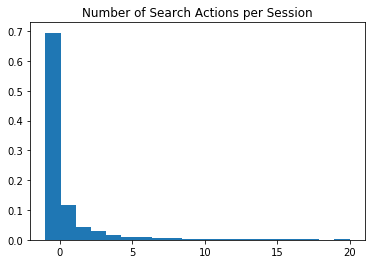

In [84]:
bin_values = np.linspace(-1, 20, 21)
plt.hist(temp, bins=bin_values, density = True)
plt.plot()
plt.title('Number of Search Actions per Session')

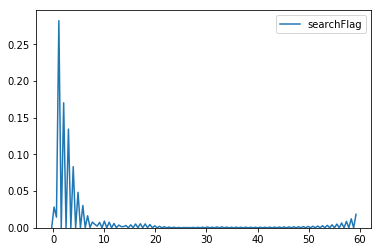

In [85]:
sns.kdeplot(temp)

#### Most frequent sequence of events

Most frequently used is Auto Complete, followed by 'Run'.  There's also high percentage of search click followed by another search click.  This indicates that Auto Complete is a popular feature, and is used more frequently than user inputting a specific search.  However, user clicking on many results within a session indicates that they could not find the result they wanted, and it signifies that search ranking algorithm needs tuning.  The frequency of 'run_click' is about the same as 'run_run'.  This indicates that users are not happy about the search results.  If they are happy with the results, the 'run_click' frequency would be higher than the 'run_run'.  'Run_Run' indicates that the modified their search criteria instead of clicking on a result.    

In [86]:
df.loc[df['searchFlag'] == True, 'search_seq'].value_counts(normalize = True)

0.ac           0.358524
0.run          0.202704
click.click    0.101081
0.click        0.078132
ac.ac          0.065869
run.click      0.058728
run.run        0.055281
click.run      0.047426
ac.run         0.015168
run.ac         0.012731
ac.click       0.002684
click.ac       0.001674
Name: search_seq, dtype: float64

#### Percentage of users that ever used each search function

0 means other activites.

In [87]:
df.pivot_table(values='user_id', columns='search_action', aggfunc=pd.Series.nunique)/df['user_id'].nunique()

search_action,0,ac,click,run
user_id,1.0,0.413217,0.119877,0.223156


Text(0.5,1,'Weekly- Unique # of users using each function')

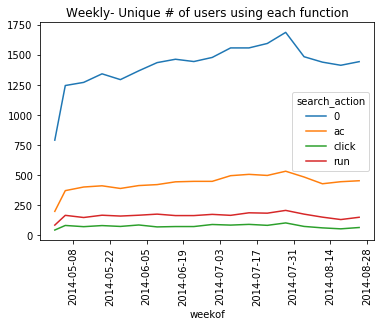

In [88]:
df.pivot_table(values='user_id', index='weekof', columns='search_action', aggfunc=pd.Series.nunique).plot()
plt.xticks(rotation=90)
plt.title('Weekly- Unique # of users using each function')

In [89]:
temp = df.pivot_table(values='user_id', index='weekof', columns='search_action', aggfunc=pd.Series.nunique)
temp = temp.divide(temp['0'], axis=0)

Text(0.5,1,'weekly % of unique users using each search feature')

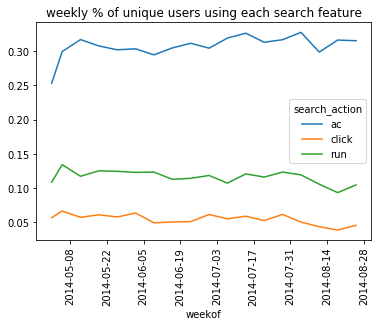

In [90]:
temp.loc[:,'ac':'run'].plot()
plt.xticks(rotation=90)
plt.title('weekly % of unique users using each search feature')

#### Percentage of sessions with search (breakdown by search_action)

21% of sessions used Auto Complete. 7% used user specific search, while clicks on the search result is only 3%.  This indicates that search results may not be relevant.

In [91]:
temp = df.groupby(['session_num'])['search_action'].value_counts().unstack()

In [92]:
temp = temp>0

In [93]:
temp.sum(axis = 0)/len(temp)

search_action
0        1.000000
ac       0.217542
click    0.033687
run      0.073694
dtype: float64

#### Breakdown of events

In [94]:
df['event_name'].value_counts(normalize = True)

home_page                 0.275986
like_message              0.173833
view_inbox                0.164116
login                     0.113282
send_message              0.097130
search_autocomplete       0.052284
search_run                0.038198
create_user               0.021412
enter_email               0.012930
enter_info                0.011360
complete_signup           0.010797
search_click_result_2     0.004398
search_click_result_1     0.004146
search_click_result_4     0.003709
search_click_result_3     0.003327
search_click_result_5     0.002840
search_click_result_6     0.002362
search_click_result_9     0.002300
search_click_result_7     0.002080
search_click_result_8     0.002024
search_click_result_10    0.001485
Name: event_name, dtype: float64

#### Count  number of search_runs  within each session if search_run is used within the session

In [95]:
temp = df.groupby('session_num')['searchRun'].sum()
temp.loc[temp>0].value_counts(normalize = True).nlargest(10)

2.0     0.194068
3.0     0.189877
4.0     0.147647
1.0     0.114120
5.0     0.105416
6.0     0.076080
7.0     0.060928
8.0     0.035139
9.0     0.027402
10.0    0.018053
Name: searchRun, dtype: float64

Search results are not very good.  Users need to make multiple searches.

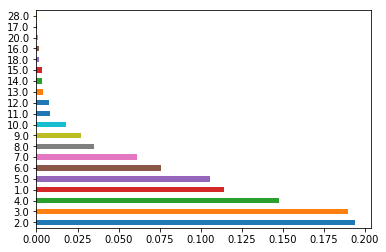

In [96]:
temp.loc[temp>0].value_counts(normalize = True).plot(kind = 'barh')

#### Count  number of search_AutoComplete within each session if search_AutoComplete is used within the session

Auto Complete seem to work better.  User mostly only used Auto Complete once per session

In [97]:
temp = df.groupby('session_num')['searchAC'].sum()

In [98]:
temp.loc[temp>0].value_counts(normalize = True).nlargest(10)

1.0     0.586437
2.0     0.184231
3.0     0.099378
4.0     0.056569
5.0     0.029376
6.0     0.021404
7.0     0.009173
8.0     0.004805
9.0     0.004041
10.0    0.002075
Name: searchAC, dtype: float64

Auto Complete Users normally has 1 auto complete action in a session, while sessions with User Defined search has multiple user-defined search actions in a session.  Users makes on average 6 clicks per session if they did click on anything in the session.

In [99]:
temp = pd.crosstab(index = df['session_num'], columns=df['search_action'])

In [100]:
temp.head(1)

search_action,0,ac,click,run
session_num,,,,
1,2,2,0,0


In [101]:
x1 = temp.loc[temp['run']>0,'run']
x2 = temp.loc[temp['ac']>0, 'ac']
x3 = temp.loc[temp['click']>0, 'click']

In [102]:
print('mean # of runs per session:', x1.mean())
print('mean # of Auto Completes per session:', x2.mean())
print('mean # of clicks per session:', x3.mean())

mean # of runs per session: 4.196969696969697
mean # of Auto Completes per session: 1.946052200502348
mean # of clicks per session: 6.891396332863188


In [103]:
print('median # of runs per session:', x1.median())
print('median # of Auto Completes per session:', x2.median())
print('median # of clicks per session:', x3.median())

median # of runs per session: 4.0
median # of Auto Completes per session: 1.0
median # of clicks per session: 6.0


/home/kiki/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/kiki/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/kiki/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[]

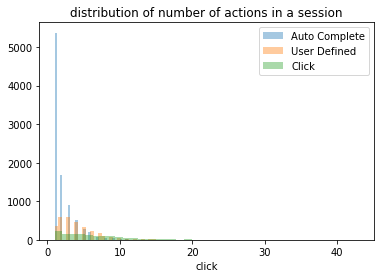

In [104]:
sns.distplot(x2, label = 'Auto Complete', kde = False)
sns.distplot(x1, label = 'User Defined', kde = False)
sns.distplot(x3, label = 'Click', kde = False)
plt.legend()
plt.title('distribution of number of actions in a session')
plt.plot()

Text(0.5,1,'Frequency of User Defined Searches per Session')

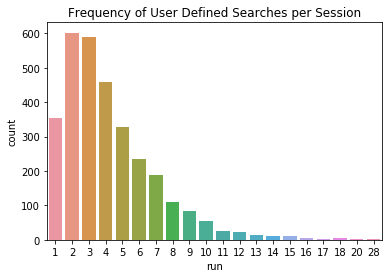

In [105]:
sns.countplot(x1)
plt.title('Frequency of User Defined Searches per Session')

Text(0.5,1,'Frequency of Auto Complete Searches per Session')

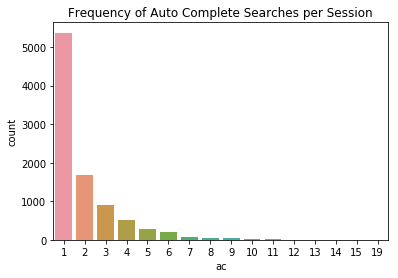

In [106]:
sns.countplot(x2)
plt.title('Frequency of Auto Complete Searches per Session')

Text(0.5,1,'Frequency of Clicks on Search Results per Session')

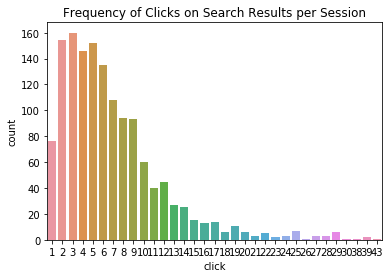

In [107]:
sns.countplot(x3)
plt.title('Frequency of Clicks on Search Results per Session')

#### Click rate if users made any user defined search in a session

In [108]:
temp = pd.crosstab(index = df['session_num'], columns=df['search_action'])
temp.shape

(42093, 4)

In [109]:
temp = temp.loc[temp['run']>0]
temp.shape

(3102, 4)

In [110]:
temp['clickFlag'] = temp['click'] > 0
temp['ratio'] = temp['click']/temp['run']

In [111]:
temp.head()

search_action,0,ac,click,run,clickFlag,ratio
session_num,,,,,,
2,2,3,0,1,False,0.0
4,2,0,6,4,True,1.5
9,10,0,0,5,False,0.0
10,2,4,0,2,False,0.0
39,9,0,0,3,False,0.0


Percentage that of searches that resulted in 0 clicks is 54%.  The search results are not very good. 

In [112]:
sum(temp['click'] == 0)/len(temp)

0.5428755641521599

People had to click so many times to get what they want.  

/home/kiki/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Frequency of click ratio for sessions with user Search')

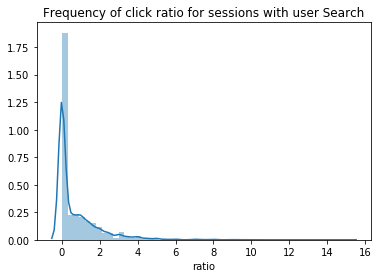

In [113]:
sns.distplot(temp['ratio'])
plt.title('Frequency of click ratio for sessions with user Search')

In [114]:
temp['ratio'].mean()

0.7451514303922144

In [115]:
temp['ratio'].median()

0.0

For the sessions where a click was made.  What is the ratio of click/run?

In [116]:
temp.groupby('clickFlag')['ratio'].median()

clickFlag
False    0.00
True     1.25
Name: ratio, dtype: float64

In [117]:
temp.groupby('clickFlag')['ratio'].mean()

clickFlag
False    0.000000
True     1.630084
Name: ratio, dtype: float64

#### Which search results are the users clicking on?

Search result is not great.  More clicks are on the 2nd result rather than 1st.

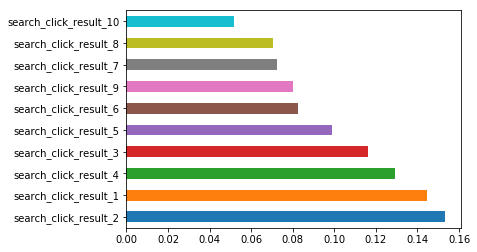

In [118]:
df[df['search_click'] == 1]['event_name'].value_counts(normalize = True).plot(kind = 'barh')

#### What is the common usage pattern?

In [119]:
df['action_seq_2'].value_counts(normalize = True).nlargest(10)

nan.nan.login                          0.102088
home_page.like_message.home_page       0.044808
nan.login.home_page                    0.042402
home_page.view_inbox.home_page         0.040463
like_message.home_page.like_message    0.028287
view_inbox.home_page.like_message      0.026330
like_message.home_page.view_inbox      0.026039
view_inbox.home_page.view_inbox        0.024044
nan.nan.create_user                    0.021412
home_page.send_message.home_page       0.019960
Name: action_seq_2, dtype: float64

In [120]:
df['search_seq_2'].value_counts(normalize = True).nlargest(10)

0.0.0        0.563606
nan.nan.0    0.123501
nan.0.0      0.099727
0.ac.0       0.035041
ac.0.0       0.020327
0.run.0      0.016298
0.0.ac       0.016105
ac.0.ac      0.013998
nan.0.ac     0.011692
run.0.run    0.011580
Name: search_seq_2, dtype: float64

In [121]:
df[df['searchFlag'] == 1]['action_seq_2'].value_counts(normalize = True).nlargest(20)

nan.login.search_autocomplete                                  0.098126
login.home_page.search_autocomplete                            0.050233
search_autocomplete.home_page.search_autocomplete              0.045333
search_run.home_page.search_run                                0.037133
nan.login.search_run                                           0.030213
search_autocomplete.like_message.search_autocomplete           0.028884
search_autocomplete.search_autocomplete.search_autocomplete    0.027997
search_autocomplete.view_inbox.search_autocomplete             0.027480
search_run.like_message.search_run                             0.023910
search_run.view_inbox.search_run                               0.023171
search_run.search_run.search_run                               0.022260
login.like_message.search_autocomplete                         0.021768
login.view_inbox.search_autocomplete                           0.020561
search_autocomplete.send_message.search_autocomplete           0

In [122]:
df[df['search_click'] == 1]['action_seq_2'].value_counts(normalize = True).nlargest(20)

search_run.home_page.search_click_result_1       0.007163
search_run.home_page.search_click_result_2       0.006959
home_page.search_run.search_click_result_2       0.006038
search_run.home_page.search_click_result_5       0.005833
search_run.home_page.search_click_result_4       0.005833
search_run.search_run.search_click_result_2      0.005424
search_run.home_page.search_click_result_3       0.005219
search_run.search_run.search_click_result_3      0.005219
home_page.search_run.search_click_result_1       0.005117
search_run.like_message.search_click_result_1    0.005014
search_run.search_run.search_click_result_1      0.004912
search_run.like_message.search_click_result_4    0.004810
search_run.search_run.search_click_result_4      0.004707
home_page.search_run.search_click_result_4       0.004605
view_inbox.search_run.search_click_result_2      0.004605
like_message.search_run.search_click_result_1    0.004400
search_run.like_message.search_click_result_2    0.004196
home_page.sear

In [123]:
df[df['search_click'] == 1]['search_seq_2'].value_counts(normalize = True).nlargest(20)

click.click.click    0.263201
click.0.click        0.174171
run.0.click          0.121572
0.run.click          0.103254
click.run.click      0.099263
0.click.click        0.078694
run.click.click      0.076955
run.run.click        0.036635
0.0.click            0.023741
ac.0.click           0.005219
ac.run.click         0.004912
run.ac.click         0.004298
0.ac.click           0.003889
click.ac.click       0.002456
ac.click.click       0.001228
ac.ac.click          0.000512
Name: search_seq_2, dtype: float64

# 3. Validating A/B Test Results

This case focuses on an improvement to Yammer’s core “publisher”—the module at the top of a Yammer feed where users type their messages. To test this feature, the product team ran an A/B test from June 1 through June 30. During this period, some users who logged into Yammer were shown the old version of the publisher (the “control group”), while other other users were shown the new version (the “treatment group”).

 On July 1, you check the results of the A/B test. You notice that message posting is 50% higher in the treatment group—a huge increase in posting. Determine whether this feature is the real deal or too good to be true. The product team is looking to you for advice about this test, and you should try to provide as much information about what happened as you can.

The dataset experiment should be used as the main dataset.  Merges and aggregations should append to this dataset.

In [124]:
expUsers = list(exp['exp_user_id'])

In [125]:
expdf = df.loc[(df['user_id'].isin(expUsers)) & (df['occurred_at'] >= '2014-06-01') & (df['occurred_at'] <= '2014-07-07')]

#### Check breadkwon of control vs test group by day

In [126]:
temp= exp.groupby(['exp_experiment_group', 'exp_date']).size().unstack().transpose()
temp = temp.fillna(0)
temp['cumControl'] = temp['control_group'].cumsum()
temp['cumTest'] = temp['test_group'].cumsum()
temp['control%Day'] = temp['control_group'] / (temp['control_group'] + temp['test_group'])
temp['test%Day'] = temp['test_group'] / (temp['control_group'] + temp['test_group'])
temp['control%cum'] = temp['cumControl'] / (temp['cumControl'] + temp['cumTest'])
temp['test%cum'] = temp['cumTest'] / (temp['cumControl'] + temp['cumTest'])

In [127]:
temp.tail()

exp_experiment_group,control_group,test_group,cumControl,cumTest,control%Day,test%Day,control%cum,test%cum
exp_date,,,,,,,,
2014-06-26,57.0,15.0,1613.0,810.0,0.791667,0.208333,0.665704,0.334296
2014-06-27,59.0,16.0,1672.0,826.0,0.786667,0.213333,0.669335,0.330665
2014-06-28,12.0,0.0,1684.0,826.0,1.000000,0.000000,0.670916,0.329084
2014-06-29,10.0,0.0,1694.0,826.0,1.000000,0.000000,0.672222,0.327778
2014-06-30,52.0,23.0,1746.0,849.0,0.693333,0.306667,0.672832,0.327168


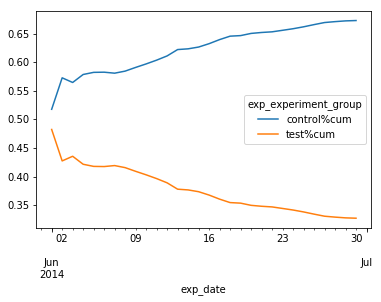

In [128]:
temp[['control%cum', 'test%cum']].plot()

#### Add experiment group to dataframe

In [129]:
expdf['exp_experiment_group'].value_counts()

na               68952
control_group    17174
test_group        7773
Name: exp_experiment_group, dtype: int64

In [130]:
controlId = exp.loc[exp['exp_experiment_group']=='control_group']['exp_user_id']
testId = exp.loc[exp['exp_experiment_group']=='test_group']['exp_user_id']

In [131]:
expdf.loc[expdf['exp_user_id'].isin(controlId), 'grp'] = 'control'
expdf.loc[expdf['exp_user_id'].isin(testId), 'grp'] = 'test'

/home/kiki/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/kiki/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [132]:
expdf['grp'].value_counts()

control    17174
test        7773
Name: grp, dtype: int64

#### Check if there's differences in user segmentation

In [133]:
exp_users = exp.merge(users, left_on = 'exp_user_id', right_on = 'user_id', how = 'left')

##### Breakdown by country is roughly the same between groups

In [134]:
temp=pd.crosstab(exp_users['exp_experiment_group'], exp_users['exp_location']).transpose()

In [135]:
temp/temp.sum(axis = 0)*100

exp_experiment_group,control_group,test_group
exp_location,,
Argentina,0.859107,0.471143
Australia,1.718213,2.591284
Austria,0.630011,0.706714
Belgium,1.088202,0.471143
Brazil,3.092784,3.415783
Canada,3.722795,1.766784
Chile,0.229095,0.353357
Colombia,0.458190,0.706714
Denmark,0.801833,0.353357


##### Breakdown by device is roughly the same

In [136]:
temp=pd.crosstab(exp_users['exp_experiment_group'], exp_users['exp_device']).transpose()
temp/temp.sum(axis = 0)*100

exp_experiment_group,control_group,test_group
exp_device,,
acer aspire desktop,1.489118,1.413428
acer aspire notebook,3.092784,2.591284
amazon fire phone,0.687285,0.824499
asus chromebook,3.264605,2.826855
dell inspiron desktop,3.264605,3.769140
dell inspiron notebook,5.956472,5.653710
hp pavilion desktop,2.978236,2.826855
htc one,1.718213,1.060071
ipad air,3.207331,2.826855


In [137]:
temp.head()

exp_experiment_group,control_group,test_group
exp_device,,
acer aspire desktop,26,12
acer aspire notebook,54,22
amazon fire phone,12,7
asus chromebook,57,24
dell inspiron desktop,57,32


##### Breakdown by User Type is different, but not what sure user_type is

In [138]:
temp=pd.crosstab(exp_users['exp_experiment_group'], exp_users['exp_user_type']).transpose()
temp/temp.sum(axis = 0)*100

exp_experiment_group,control_group,test_group
exp_user_type,,
1.0,28.522337,46.407538
2.0,27.147766,24.734982
3.0,44.329897,28.857479


#### Language breakdown is roughly the same

In [139]:
temp=pd.crosstab(exp_users['exp_experiment_group'], exp_users['language']).transpose()
temp/temp.sum(axis = 0)*100

exp_experiment_group,control_group,test_group
language,,
arabic,3.550974,3.651355
chinese,3.150057,3.886926
english,51.947308,51.707892
french,8.419244,6.949352
german,5.441008,5.418139
indian,3.207331,2.591284
italian,2.462772,1.884570
japanese,6.185567,7.067138
korean,1.660939,1.766784


#### All the new customers are in the Control Group

In [140]:
exp_users['activated_at'] = pd.to_datetime(exp_users['activated_at'])
exp_users['daysOnPlatform'] = (exp_users['exp_date']-exp_users['activated_at']).dt.days

In [141]:
exp_users.groupby('exp_experiment_group').agg({'daysOnPlatform':['min', 'max', 'mean', 'median', 'std']})

daysOnPlatform                                    
                                min  max        mean median         std
exp_experiment_group                                                   
control_group                    -1  531   86.561283      0  134.401085
test_group                        3  531  176.153121    139  147.530865

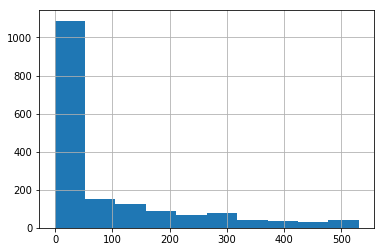

In [142]:
exp_users.loc[exp_users['exp_experiment_group'] == 'control_group', 'daysOnPlatform'].hist()

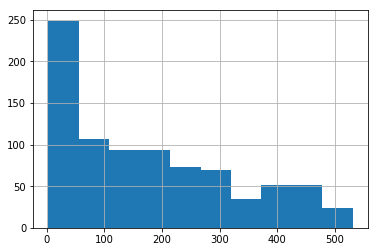

In [143]:
exp_users.loc[exp_users['exp_experiment_group'] == 'test_group', 'daysOnPlatform'].hist()

#### Add number of days in experiment

In [144]:
expdf.loc[expdf['exp_date']=='na', 'exp_date'] = np.nan
expdf.loc[expdf['exp_occurred_at']=='na', 'exp_occurred_at'] = np.nan

/home/kiki/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [145]:
expdf['exp_date'] = expdf.groupby('user_id')['exp_date'].fillna(method = 'ffill')
expdf['exp_date'] = pd.to_datetime(expdf['exp_date'])
expdf['days_in_exp'] = (expdf['occurred_at']-expdf['exp_date']).dt.days
expdf['grp'] = expdf.groupby('user_id')['grp'].fillna(method = 'ffill')

/home/kiki/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/kiki/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/kiki/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

#### Filter sessions for week starting from 2014/06/30 - 2014/07/06

In [146]:
weekly = expdf.loc[expdf['weekof'] == dt.date(2014,6,30)]

Number of user_ids in control and experiment

In [147]:
count = exp_users.groupby('exp_experiment_group')['exp_user_id'].count()
count

exp_experiment_group
control_group    1746
test_group        849
Name: exp_user_id, dtype: int64

#### How many occurances of each event_name happened during the week.  

In [148]:
summary = weekly.groupby(['grp', 'event_name']).size().unstack()
summary = summary[['login', 'like_message', 'home_page', 'send_message' ]]
summary

event_name,login,like_message,home_page,send_message
grp,,,,
control,1204.0,1823.0,2887.0,973.0
test,616.0,1052.0,1684.0,619.0


#### Normalize the frequency of event_name by number of users in each group

After divide the frequency by number of users in each group, the experiment group has higher engagment in every aspect.

In [149]:
summary.loc['control',:]/1746

event_name
login           0.689576
like_message    1.044101
home_page       1.653494
send_message    0.557274
Name: control, dtype: float64

In [150]:
summary.loc['test',:]/849

event_name
login           0.725559
like_message    1.239105
home_page       1.983510
send_message    0.729093
Name: test, dtype: float64

#### Are these differences statistically significant?

In [151]:
weekly['login'] = weekly['event_name'] == 'login'
weekly['send_msg'] = weekly['event_name'] == 'send_message'

/home/kiki/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/kiki/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [152]:
exp_users = exp_users.set_index('exp_user_id')

In [153]:
temp = weekly.groupby(['user_id'])['login'].agg('sum')
exp_users['login_week'] = temp

In [154]:
temp = weekly.groupby(['user_id'])['send_msg'].agg('sum')
exp_users['msg_week'] = temp

In [155]:
temp = weekly.groupby(['user_id'])['session_num'].agg('nunique')
exp_users['session_week'] = temp

In [156]:
exp_users['login_week'] = exp_users['login_week'].fillna(0)
exp_users['msg_week'] = exp_users['msg_week'].fillna(0)
exp_users['session_week'] = exp_users['session_week'].fillna(0)

In [157]:
exp_users['msgPerLogin_week'] = exp_users['msg_week']/exp_users['login_week']
exp_users['msgPerLogin_week'] = exp_users['msgPerLogin_week'].fillna(0)

In [158]:
exp_users.agg({'login_week':['mean', 'std', 'var'], 'msg_week':['mean', 'std', 'var'], 
               'session_week':['mean', 'std', 'var', 'size'],
              'msgPerLogin_week': ['mean', 'std', 'var', 'size']})

,login_week,msg_week,session_week,msgPerLogin_week
mean,0.701349,0.613487,0.699037,0.303204
size,NaN,NaN,2595.000000,2595.000000
std,1.128168,1.434153,1.123443,0.629839
var,1.272762,2.056796,1.262123,0.396697


In [159]:
exp_users.groupby('exp_experiment_group').agg({'login_week':['mean', 'std', 'var', 'size'], 
                                               'msg_week':['mean', 'std', 'var'],
                                              'session_week':['mean', 'std', 'var'],
                                               'msgPerLogin_week':['mean', 'std', 'var']})

login_week                            msg_week            \
                           mean       std       var  size      mean       std   
exp_experiment_group                                                            
control_group          0.689576  1.104757  1.220487  1746  0.557274  1.380331   
test_group             0.725559  1.175143  1.380962   849  0.729093  1.533314   

                               session_week                      \
                           var         mean       std       var   
exp_experiment_group                                              
control_group         1.905314     0.687285  1.100471  1.211036   
test_group            2.351051     0.723204  1.169559  1.367869   

                     msgPerLogin_week                      
                                 mean       std       var  
exp_experiment_group                                       
control_group                0.274216  0.598812  0.358576  
test_group                   0.362819  0.685800  0.470322

#### Inference for comparing two independent means


In [160]:
from scipy import stats

Standard Error of differences between two independent means:


In [161]:
seC = 1.220487/1746
seT = 1.380962/849
SE = np.sqrt(seC+seT)
SE

0.04822440973427036

Degree of freedom

In [162]:
degF = min((1746-1),(849-1))
degF

848

In [163]:
tStat = (0.689576-0.725559)/SE
tStat

-0.746157396187452

In [164]:
pval = stats.t.sf(np.abs(tStat), degF)*2  # two-sided pvalue = Prob(abs(t)>tt)
pval

0.4557791333422436

In [165]:
x1 = exp_users.loc[exp_users['exp_experiment_group'] == 'control_group', 'login_week']
x2 = exp_users.loc[exp_users['exp_experiment_group'] == 'test_group', 'login_week']

Failed to reject Null, there's no differences between login per week between the two groups

In [166]:
stats.ttest_ind(x1, x2, equal_var = False)

Ttest_indResult(statistic=-0.7461638433865483, pvalue=0.4556787004701507)

Reject Null, there is differences between the messages sent between the two groups.

In [167]:
x1 = exp_users.loc[exp_users['exp_experiment_group'] == 'control_group', 'msg_week']
x2 = exp_users.loc[exp_users['exp_experiment_group'] == 'test_group', 'msg_week']
stats.ttest_ind(x1, x2, equal_var = False)

Ttest_indResult(statistic=-2.7653696252095643, pvalue=0.005754031617115767)

Reject Null, there is differences between the messages per login sent between the two groups.

In [168]:
x1 = exp_users.loc[exp_users['exp_experiment_group'] == 'control_group', 'msgPerLogin_week']
x2 = exp_users.loc[exp_users['exp_experiment_group'] == 'test_group', 'msgPerLogin_week']
stats.ttest_ind(x1, x2, equal_var = False)

Ttest_indResult(statistic=-3.215373391832616, pvalue=0.00133061894890236)

Failed to reject Null, there's no differences between sessions per week between the two groups

In [169]:
x1 = exp_users.loc[exp_users['exp_experiment_group'] == 'control_group', 'session_week']
x2 = exp_users.loc[exp_users['exp_experiment_group'] == 'test_group', 'session_week']
stats.ttest_ind(x1, x2, equal_var = False)

Ttest_indResult(statistic=-0.7481798097097158, pvalue=0.4544622219708587)

#### Check if there is correlation between days on platform vs. usage in login, msg, session

Slight negligible correlation between number of days on platform vs the engagement.    The number of days since participating in the experiment correlates negatively with engagement.

In [170]:
exp_users['days_in_exp'] = pd.to_datetime(dt.date(2014,6,30))
exp_users['days_in_exp'] = (exp_users['days_in_exp']-exp_users['exp_date']).dt.days

exp_users['daysOnPlatform'] = (pd.to_datetime(dt.date(2014,6,30))-exp_users['activated_at']).dt.days
exp_users['cohert'] = pd.cut(exp_users['daysOnPlatform'], bins = [-1, 7, 15, 30, 90, 180, 360, exp_users['daysOnPlatform'].max()],
                     labels =  ['<7d', '<15d', '<30d', '<90d', '<180d', '<360d', '>360d'])
exp_users['cohert'] = exp_users['cohert'].astype('object')
exp_users['cohert'] = exp_users['cohert'].fillna('<7d')

In [171]:
subdf = exp_users[['daysOnPlatform', 'days_in_exp', 'login_week', 'msg_week', 'session_week', 'msgPerLogin_week']]

In [172]:
subdf.corr(method='pearson')

,daysOnPlatform,days_in_exp,login_week,msg_week,session_week,msgPerLogin_week
daysOnPlatform,1.000000,0.120290,0.031187,0.050330,0.031852,0.040517
days_in_exp,0.120290,1.000000,-0.229479,-0.138149,-0.230843,-0.160734
login_week,0.031187,-0.229479,1.000000,0.780665,0.999098,0.564327
msg_week,0.050330,-0.138149,0.780665,1.000000,0.780044,0.823312
session_week,0.031852,-0.230843,0.999098,0.780044,1.000000,0.564704
msgPerLogin_week,0.040517,-0.160734,0.564327,0.823312,0.564704,1.000000


The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. The test is applied to samples from two or more groups, possibly with differing sizes.

In [173]:
exp_users.groupby('cohert')['msg_week'].mean().sort_values(ascending = False)

cohert
<7d      1.083333
>360d    0.776978
<360d    0.742000
<180d    0.580729
<15d     0.521186
<90d     0.426136
<30d     0.386091
Name: msg_week, dtype: float64

In [174]:
exp_users.groupby('cohert')['login_week'].mean().sort_values(ascending = False)

cohert
<7d      1.341270
<360d    0.792000
>360d    0.791367
<15d     0.694915
<180d    0.690104
<90d     0.475379
<30d     0.446043
Name: login_week, dtype: float64

In [175]:
exp_users.groupby('cohert')['msgPerLogin_week'].mean().sort_values(ascending = False)

cohert
<7d      0.534656
>360d    0.366007
<180d    0.334834
<360d    0.323142
<15d     0.249364
<90d     0.220770
<30d     0.203277
Name: msgPerLogin_week, dtype: float64

In [176]:
exp_users.groupby(['exp_experiment_group','cohert'])['msg_week'].mean().sort_values(ascending = False).unstack()

cohert,<15d,<180d,<30d,<360d,<7d,<90d,>360d
exp_experiment_group,,,,,,,
control_group,0.521186,0.352679,0.400504,0.614458,1.083333,0.335968,0.748148
test_group,NaN,0.900000,0.100000,0.868526,NaN,0.509091,0.804196


In [177]:
exp_users.groupby(['exp_experiment_group','cohert'])['login_week'].mean().sort_values(ascending = False).unstack()

cohert,<15d,<180d,<30d,<360d,<7d,<90d,>360d
exp_experiment_group,,,,,,,
control_group,0.694915,0.575893,0.458438,0.710843,1.34127,0.434783,0.770370
test_group,NaN,0.850000,0.200000,0.872510,NaN,0.512727,0.811189


In [178]:
exp_users.groupby(['exp_experiment_group','cohert'])['msgPerLogin_week'].mean().sort_values(ascending = False).unstack()

cohert,<15d,<180d,<30d,<360d,<7d,<90d,>360d
exp_experiment_group,,,,,,,
control_group,0.249364,0.206622,0.20848,0.267793,0.534656,0.193544,0.300000
test_group,NaN,0.514330,0.10000,0.378050,NaN,0.245818,0.428322


In [228]:
x1 = exp_users.groupby('days_in_exp')['msgPerLogin_week'].mean().sort_index(ascending = True)

In [229]:
x2 = exp_users.groupby(['exp_experiment_group','days_in_exp'])['msgPerLogin_week'].mean().sort_values(ascending = False).unstack().T

In [232]:
temp = pd.concat([x1, x2], axis=1)

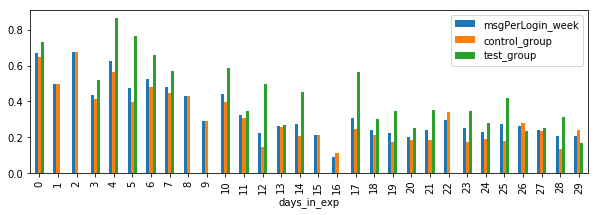

In [255]:
temp.plot(kind = 'bar')
# matplotlib.rcParams['figure.figsize'] = [width, height]
plt.rcParams['figure.figsize'] = [10,10]

#### There's login count differences between coherts

In [179]:
x1 = exp_users.loc[exp_users['cohert'] == '<7d', 'login_week' ]
x2 = exp_users.loc[exp_users['cohert'] == '<360d', 'login_week' ]
x3 = exp_users.loc[exp_users['cohert'] == '>360d', 'login_week' ]
x4 = exp_users.loc[exp_users['cohert'] == '<15d', 'login_week' ]
x5 = exp_users.loc[exp_users['cohert'] == '<180d', 'login_week' ]
x6 = exp_users.loc[exp_users['cohert'] == '<90d', 'login_week' ]
x7 = exp_users.loc[exp_users['cohert'] == '<30d', 'login_week' ]

In [180]:
stats.f_oneway(x1, x2, x3, x4, x5, x6, x7)

F_onewayResult(statistic=22.510426373242762, pvalue=5.480989176370399e-26)

#### There's msg sent count differences between coherts

In [181]:
x1 = exp_users.loc[exp_users['cohert'] == '<7d', 'msg_week' ]
x2 = exp_users.loc[exp_users['cohert'] == '<360d', 'msg_week' ]
x3 = exp_users.loc[exp_users['cohert'] == '>360d', 'msg_week' ]
x4 = exp_users.loc[exp_users['cohert'] == '<15d', 'msg_week' ]
x5 = exp_users.loc[exp_users['cohert'] == '<180d', 'msg_week' ]
x6 = exp_users.loc[exp_users['cohert'] == '<90d', 'msg_week' ]
x7 = exp_users.loc[exp_users['cohert'] == '<30d', 'msg_week' ]

In [182]:
stats.f_oneway(x1, x2, x3, x4, x5, x6, x7)

F_onewayResult(statistic=9.403782648152085, pvalue=3.107742077919664e-10)

#### There's msg sent count differences per login between coherts

In [183]:
x1 = exp_users.loc[exp_users['cohert'] == '<7d', 'msgPerLogin_week' ]
x2 = exp_users.loc[exp_users['cohert'] == '<360d', 'msgPerLogin_week' ]
x3 = exp_users.loc[exp_users['cohert'] == '>360d', 'msgPerLogin_week' ]
x4 = exp_users.loc[exp_users['cohert'] == '<15d', 'msgPerLogin_week' ]
x5 = exp_users.loc[exp_users['cohert'] == '<180d', 'msgPerLogin_week' ]
x6 = exp_users.loc[exp_users['cohert'] == '<90d', 'msgPerLogin_week' ]
x7 = exp_users.loc[exp_users['cohert'] == '<30d', 'msgPerLogin_week' ]

In [184]:
stats.f_oneway(x1, x2, x3, x4, x5, x6, x7)

F_onewayResult(statistic=10.131053998615139, pvalue=4.235895467754582e-11)

####  Can we predict "msgPerLogin_week"?

In [186]:
cols = ['exp_experiment_group', 'exp_location', 'exp_device',
       'exp_user_type', 'company_id',
       'language', 'state', 'daysOnPlatform',
       'days_in_exp', 'cohert','msgPerLogin_week']

In [187]:
enum_df = exp_users[cols].select_dtypes(include=['object'])
num_df = exp_users[cols].select_dtypes(exclude=['object'])

In [188]:
enum_df = pd.get_dummies(enum_df)

In [189]:
combined = pd.concat([num_df, enum_df], axis=1)

In [190]:
y = combined['msgPerLogin_week']
X = combined.drop('msgPerLogin_week', axis = 1)

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#### Make a single tree to see which decisions are important

In [212]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [213]:
m.score(X_train, y_train)

0.1916161286719017

In [214]:
m.score(X_test, y_test)

0.2090664053508098

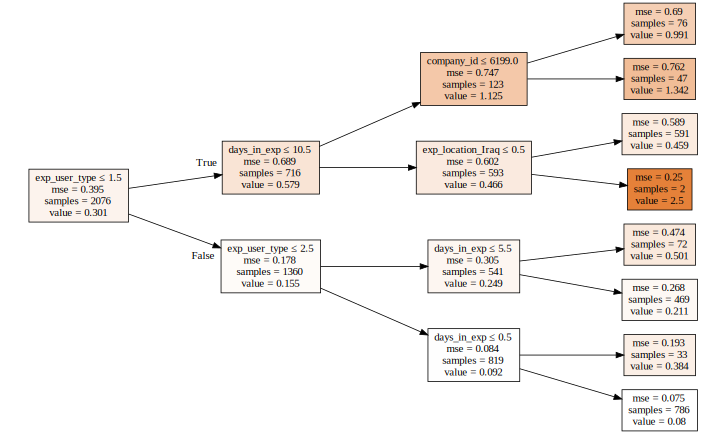

In [215]:
draw_tree(m.estimators_[0], X_train, precision=3)

In [216]:
m = RandomForestRegressor(n_estimators=1, max_depth=4, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print('train:', m.score(X_train, y_train))
print('test:',m.score(X_test, y_test))

train: 0.22147178134126821
test: 0.19553693899594904


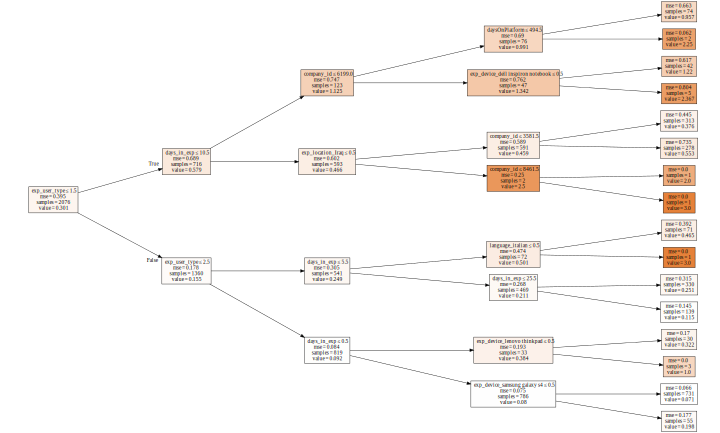

In [217]:
draw_tree(m.estimators_[0], X_train, precision=3)

The model will be horrible because it does not have many meaningful features.

In [256]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print('train:', m.score(X_train, y_train))
print('test:',m.score(X_test, y_test))

train: 0.8228490107447078
test: 0.028226394132938485


In [264]:
importances = pd.DataFrame(m.feature_importances_, index = X_train.columns)

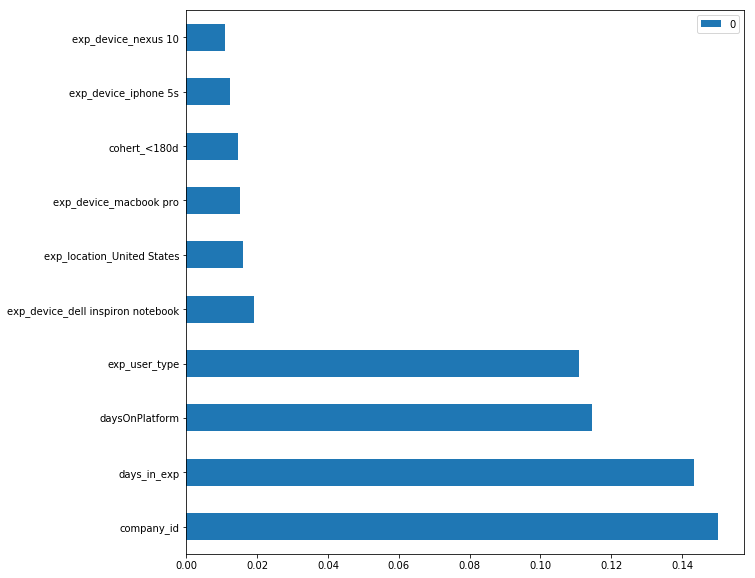

In [285]:
importances.nlargest(10, 0).plot(kind = 'barh')